In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage import io
from skimage.color import rgb2gray
from skimage import exposure
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.morphology import closing
from skimage.morphology import square as squared
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology,feature,measure,filters


%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


# Load the individual images and stitch them together

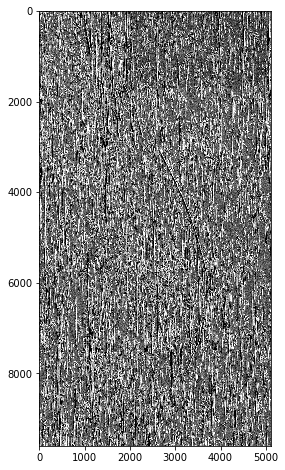

In [3]:
DIR = os.path.join(os.getcwd(), 'SEM-images')
nws_row1 = np.concatenate((io.imread(os.path.join(DIR, '10001.tif')), io.imread(os.path.join(DIR, '10002.tif'))), axis=1)
nws_row2 = np.concatenate((io.imread(os.path.join(DIR, '10003.tif')), io.imread(os.path.join(DIR, '10004.tif'))), axis=1)
nws_row3 = np.concatenate((io.imread(os.path.join(DIR, '10005.tif')), io.imread(os.path.join(DIR, '10006.tif'))), axis=1)
nws_row4 = np.concatenate((io.imread(os.path.join(DIR, '10007.tif')), io.imread(os.path.join(DIR, '10008.tif'))), axis=1)
nws_row5 = np.concatenate((io.imread(os.path.join(DIR, '10009.tif')), io.imread(os.path.join(DIR, '10010.tif'))), axis=1)
nws = np.concatenate((nws_row1, nws_row2, nws_row3, nws_row4, nws_row5), axis=0)
plt.imshow(nws, cmap='gray')

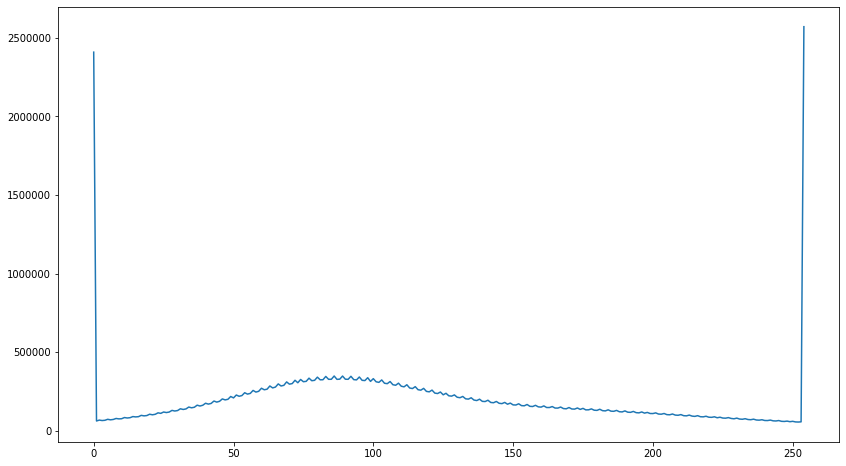

In [4]:
histo = np.histogram(nws, bins=np.arange(256))
plt.plot(histo[1][:-1], histo[0])

# Threshold-based segmentation

threshold = 132


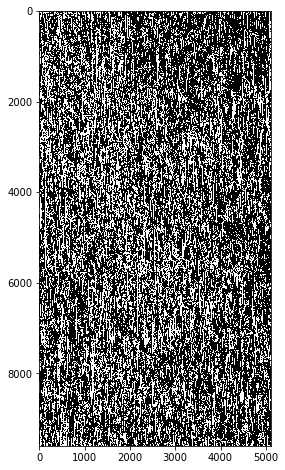

In [5]:
thresh = threshold_otsu(nws)
#thresh = 150
print('threshold = %d' % thresh)

nws_thresh = nws
mask_light = nws > thresh
nws_thresh[mask_light] = 255
mask_dark = nws < thresh
nws_thresh[mask_dark] = 0
plt.imshow(nws_thresh, cmap="gray")

In [6]:
s = ndi.generate_binary_structure(2,2)
print(s)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [7]:
#s = ndi.generate_binary_structure(2,2)   
s = [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]   # 8近邻模式
label_objects, nb_labels = ndi.label(nws_thresh, structure=s)   #nws_thresh是阈值过滤后的图像
print('label_object:',label_objects)  #被标记的矩阵
print('nb_labels:',nb_labels)  #标记的个数
sizes = np.bincount(label_objects.ravel())
print('sizes:',sizes)
mask_sizes = sizes > 200  #大于200个像素点的集团
print('mask_sizes:',mask_sizes)
mask_sizes[0] = 0  #去掉200个像素点的集团
print('mask_sizes:',mask_sizes)  
nws_thresh_cleaned = mask_sizes[label_objects]  #去掉面积小于等于200的集团
print('nws_thresh_cleaned:',nws_thresh_cleaned)

label_object: [[     1      1      1 ...      0      0      0]
 [     1      1      1 ...      0      0      0]
 [     1      1      1 ...      0      0      0]
 ...
 [     0      0      0 ... 841599 841599 841599]
 [     0      0      0 ... 841599 841599 841599]
 [     0      0      0 ... 841599 841599 841599]]
nb_labels: 842726
sizes: [31902495  5421914        2 ...        1        1        1]
mask_sizes: [ True  True False ... False False False]
mask_sizes: [False  True False ... False False False]
nws_thresh_cleaned: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


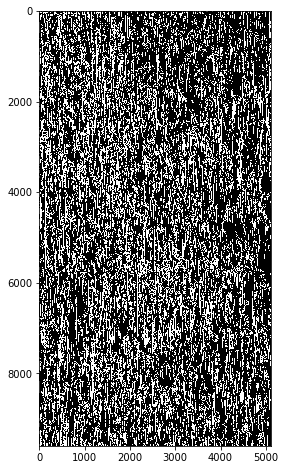

In [8]:
plt.imshow(nws_thresh_cleaned, cmap="gray")

In [33]:
#返回所有连通区块的属性列表 Returns a list of attributes for all connected blocks
from skimage.measure import regionprops
prop = regionprops(np.array(nws_thresh_cleaned).astype(int))
print(type(prop))
print('centroid:',prop[0].centroid,'\n',
      'area:',prop[0].area,'\n',
      'perimeter:',prop[0].perimeter,'\n')

<class 'list'>
centroid: (4859.845173683464, 2435.823839017766) 
 area: 15629352 
 perimeter: 5781187.951723529 



In [97]:
nws_thresh_cleaned_marked


array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [98]:
for i in nws_thresh_cleaned_marked:
    for j in i:
       if nws_thresh_cleaned_marked[i,j]==0:
        nws_thresh_cleaned_marked[i,j] = (0,0,0)
        else:
            nws_thresh_cleaned_marked[i,j] = (255,255,255)
            
    

SyntaxError: invalid syntax (<ipython-input-98-f5d29c355491>, line 5)

In [79]:
nws_thresh_cleaned_marked = nws_thresh_cleaned  #image size: 9600*5120
nws_thresh_cleaned_marked[ prop[0].coords[:,0], prop[0].coords[:,1] ] = (255,0,0) # I want to make one of the nanowire red.

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (15629352,)

# Region-based segmentation

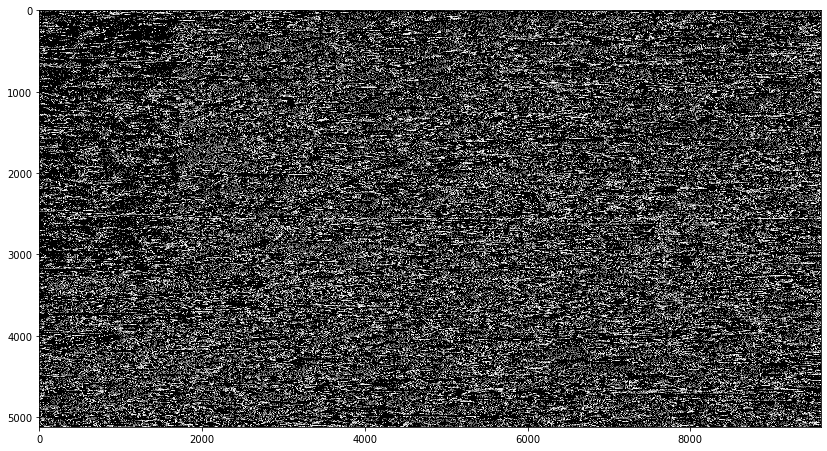

In [95]:
from skimage.filters import sobel
elevation_map = sobel(nws)  # this is edgs 这是边缘
plt.imshow(ndi.rotate(elevation_map, 90), cmap="gray")

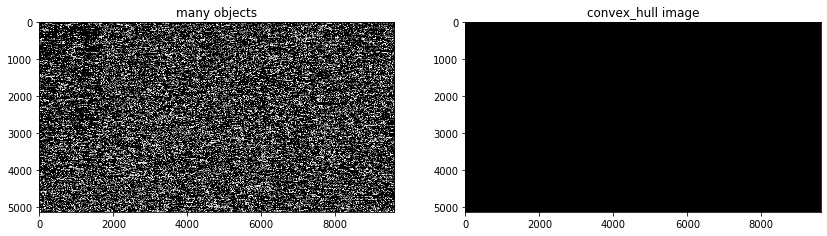

In [96]:
#edgs=feature.canny(nws)#, sigma=.1)#,low_threshold=0, high_threshold=255) 
edgs = elevation_map
chull = morphology.convex_hull_object(edgs)

#绘制轮廓 Draw outline
fig, axes = plt.subplots(1,2)
ax0, ax1= axes.ravel()
ax0.imshow(ndi.rotate(edgs,90),plt.cm.gray)
ax0.set_title('many objects')
ax1.imshow(ndi.rotate(chull,90),plt.cm.gray)
ax1.set_title('convex_hull image')
plt.show()

In [ ]:
#检测所有图形的轮廓 Detecting contours of all graphics
contours = measure.find_contours(nws, 0.5)

#绘制轮廓  Draw outline
fig, axes = plt.subplots(1,2) #,figsize=(8,8))
ax0, ax1= axes.ravel()
ax0.imshow(nws,plt.cm.gray)
ax0.set_title('original image')

rows,cols=nws.shape
ax1.axis([0,rows,cols,0])
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax1.axis('image')
ax1.set_title('contours')
plt.show()

<font color=Chocolate size=3> name 'markers' is not defined </font>

<font color=gray>from skimage.morphology import watershed<br> 
  segmentation = watershed(elevation_map, markers)<br> 
  plt.imshow(segmentation, cmap="gray")<br> </font>


# Distance-based watershed segmentation

In [51]:
distance = ndi.distance_transform_edt(nws) #距离变换 Range conversion
local_maxi =feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),labels=nws) #寻找峰值 Search for peak value
markers = ndi.label(local_maxi)[0] #初始标记点 Initial marker points
labels =morphology.watershed(-distance, markers, mask=nws) #基于距离变换的分水岭算法 Watershed algorithm based on distance transformation

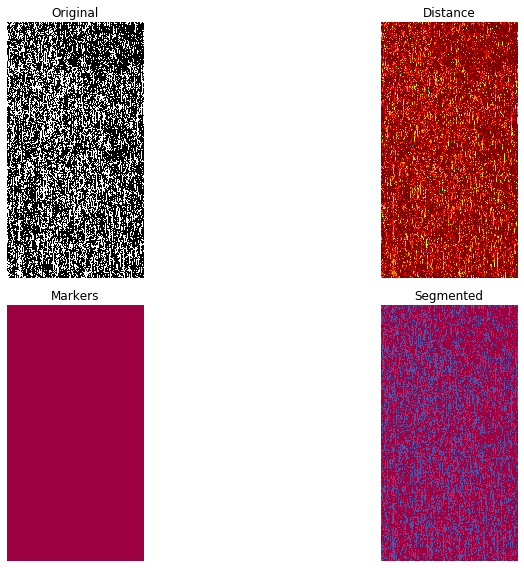

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2)  #figsize=(8, 8)
axes = axes.ravel()
ax0, ax1, ax2, ax3 = axes

ax0.imshow(nws, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title("Original")
ax1.imshow(-distance, cmap=plt.cm.jet, interpolation='nearest')
ax1.set_title("Distance")
ax2.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax2.set_title("Markers")
ax3.imshow(labels, cmap="Spectral", interpolation='nearest')
ax3.set_title("Segmented")

for ax in axes:
    ax.axis('off')

fig.tight_layout()
plt.show()

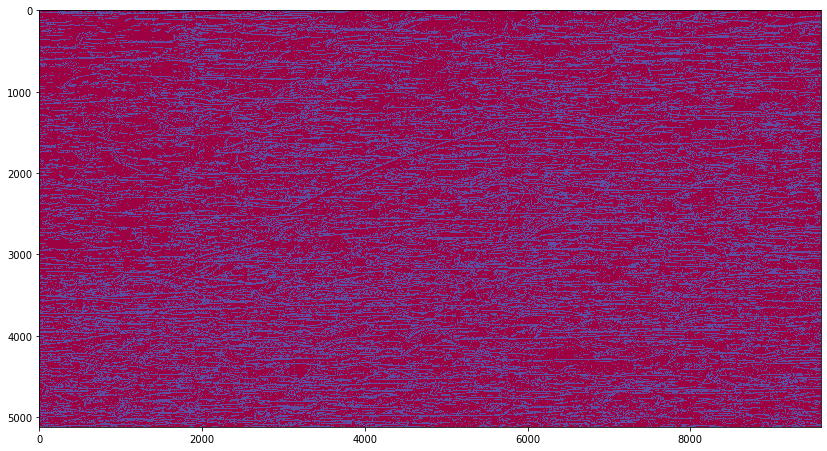

In [85]:
plt.imshow(ndi.rotate(labels,90),cmap="Spectral",interpolation='nearest') #放大 Zoom in

<font color=Chocolate size=3> name 'segmentation' is not defined </font>

<font color=gray> s = ndi.generate_binary_structure(2,2)<br>
label_objects, nb_labels = ndi.label(segmentation-1, structure = s)<br>
sizes = np.bincount(label_objects.ravel())<br>
mask_sizes = sizes > 200<br>
mask_sizes[0] = 0<br>
nws_segmented_cleaned = mask_sizes[label_objects]<br>
plt.imshow(nws_segmented_cleaned, cmap="gray")</font>

# Gradient-based watershed segmentation

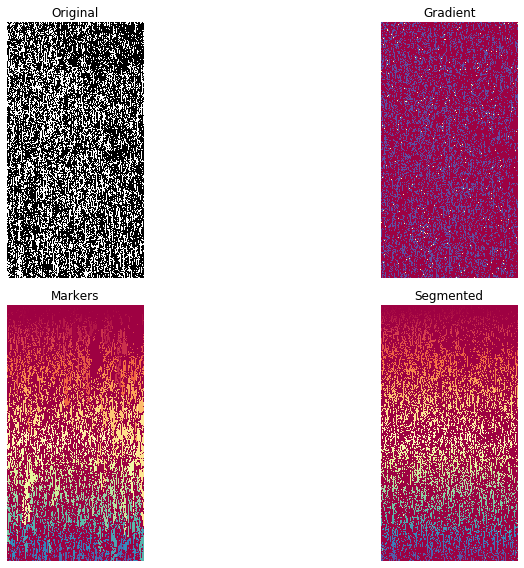

In [40]:
denoised = filters.rank.median(nws, morphology.disk(2)) #过滤噪声 Filtering noise

#将梯度值低于5的作为开始标记点 Use gradient less than 5 as the starting marker
markers = filters.rank.gradient(denoised, morphology.disk(5)) <5 #可以尝试更多的值 We can try more values.
markers = ndi.label(markers)[0]

gradient = filters.rank.gradient(denoised, morphology.disk(2)) #计算梯度 Computational gradient
labels =morphology.watershed(gradient, markers, mask=nws) #基于梯度的分水岭算法 Gradient-based watershed algorithm

fig, axes = plt.subplots(nrows=2, ncols=2)  #, figsize=(6, 6)
axes = axes.ravel()
ax0, ax1, ax2, ax3 = axes

ax0.imshow(nws, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title("Original")
ax1.imshow(gradient, cmap=plt.cm.Spectral, interpolation='nearest')
ax1.set_title("Gradient")
ax2.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax2.set_title("Markers")
ax3.imshow(labels, cmap=plt.cm.Spectral, interpolation='nearest')
ax3.set_title("Segmented")

for ax in axes:
    ax.axis('off')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Markers')

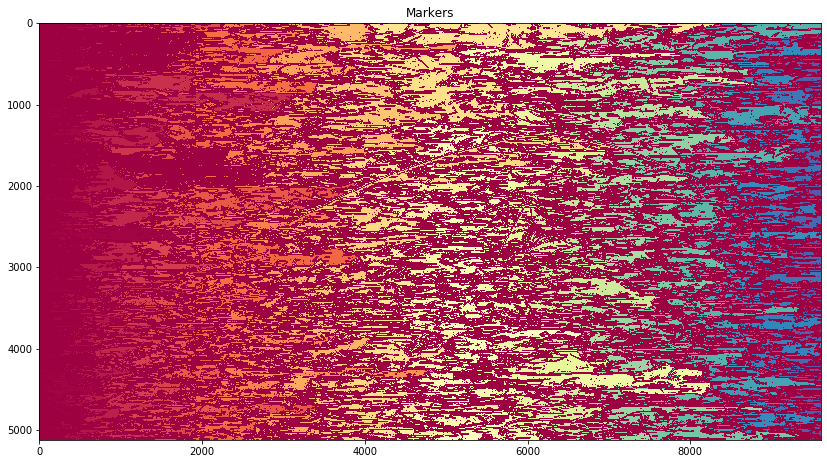

In [47]:
plt.imshow(ndi.rotate(markers,90), cmap=plt.cm.Spectral, interpolation='nearest')
plt.title("Markers")

Text(0.5, 1.0, 'Segmented')

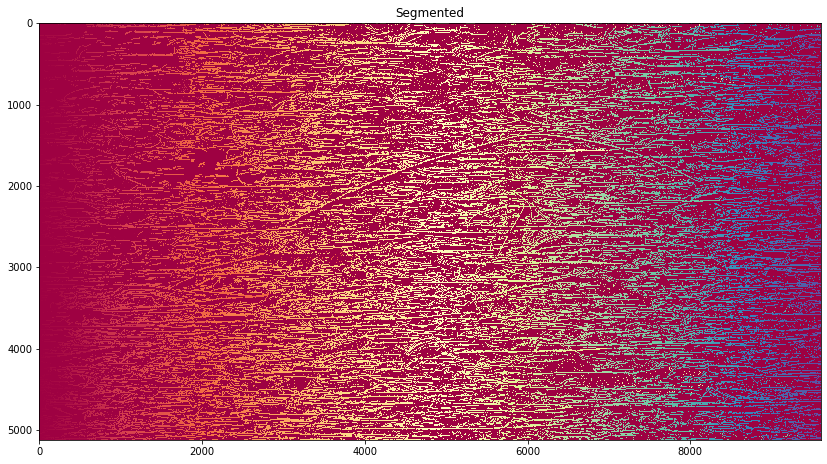

In [50]:
plt.imshow(ndi.rotate(labels,90), cmap=plt.cm.Spectral, interpolation='nearest')
plt.title('Segmented')

# fdfdfdf

In [ ]:
H = 15.9 # Height of each image in microns
W = 21.2 # Width of each image in microns
pic1 = io.imread(os.path.join(DIR, '10001.tif'))
dx = W/float(np.shape(pic1)[1]) # Width of each pixel in microns
dy = H/float(np.shape(pic1)[0]) # Height of each pixel in microns

In [ ]:
print(dx)
print(dy)


In [ ]:
def makeElectrodes(w, l, s):
    """
    """
    canvas = np.zeros((2*l+s, w))
    canvas[0:l, :] = 1
    canvas[l+s:, :] = 1
    return img_as_ubyte(canvas)

In [ ]:
def trial(image, w, l, s):
    """
    """
    x = randint(0, shape(nws)[1]-w, dtype='int')
    print('x = ' + str(x))
    y = randint(0, shape(nws)[0]-(2*l+s), dtype='int')
    print('y = ' + str(y))
    electrodes = makeElectrodes(w, l, s)
    temp_image = img_as_ubyte(image)
    temp_image[y:y+2*l+s, x:x+w] += electrodes 
   # image = image/2
    return img_as_ubyte(temp_image), x, y

In [ ]:
A = np.zeros((np.size(nws_thresh_cleaned, 0), np.size(nws_thresh_cleaned, 1)))
A, x, y = trial(nws_thresh_cleaned, 500, 100, 500)
plt.imshow(A[y:y+700, x:x+500], cmap='gray')

In [ ]:
labels = label(A, connectivity=2)
labels[y:y+700, x:x+500]

In [ ]:
labels[y+1, x+1]

In [ ]:
labels[y+3, x+2]

In [ ]:
mask_dev = labels == labels[y, x]
print(mask_dev[y-1:y+101, x-1:x+501])

In [ ]:
plt.imshow(mask_dev, cmap='gray')

In [ ]:
labeled_final = label(mask_dev)

In [ ]:
labeled_final_overlay = label2rgb(labeled_final, image=A)

In [ ]:
plt.imshow(labeled_final_overlay)

In [ ]:
labeled_final_overlay

In [4]:
for region in regionprops(labeled_final):
    print(region.area)

NameError: name 'labeled_final' is not defined